In [1]:
from shapely.geometry import box, Point, LineString
import pyrosm
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy import stats
import geopandas
import pandas as pd
import numpy as np
import random
import networkx as nx
import math
from rasterio.crs import CRS
from sys import getsizeof

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 50
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [3]:
# convenience function for printing
def print_size(obj, suffix='B'):
    num = getsizeof(obj)
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    print("%.1f%s%s" % (num, 'Yi', suffix))

In [4]:
%%time
import pickle
from pathlib import Path

class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
    
households_gdf = pickle.loads(Path('pickles/south_london/households_gdf').read_bytes())
people = pickle.loads(Path('pickles/south_london/people_list').read_bytes())
trimmed_work = pickle.loads(Path('pickles/south_london/workplaces_gdf').read_bytes())
boundary = pickle.loads(Path('pickles/south_london/boundary').read_bytes())

CPU times: user 6.72 s, sys: 1.42 s, total: 8.14 s
Wall time: 8.14 s


<AxesSubplot:>

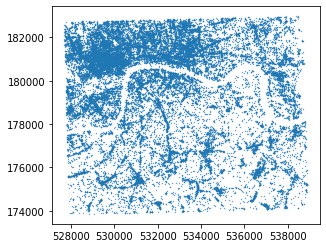

In [5]:
trimmed_work = trimmed_work.to_crs(OUT_CRS)
trimmed_work.plot(markersize=0.1)

In [6]:
%%time
# get all public transport
full_edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
full_nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
full_nodes = geopandas.GeoDataFrame(full_nodes, geometry=geopandas.points_from_xy(full_nodes.lon, full_nodes.lat), crs="EPSG:4326")
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
nodes = geopandas.clip(full_nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = full_edges[full_edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
ori_edges = full_edges[full_edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
unclipped_edges = des_edges.merge(ori_edges) # inner merge to get edges that start and end in the boundary

CPU times: user 2.88 s, sys: 188 ms, total: 3.06 s
Wall time: 3.06 s


In [7]:
%%time
# Draw lines for the edges
old_index = full_nodes.index
full_nodes = full_nodes.set_index(['node', 'layer'])
unclipped_edges = geopandas.GeoDataFrame(unclipped_edges, geometry=unclipped_edges.apply(lambda x: LineString([
    full_nodes.loc[(x.ori_node, x.ori_layer)].geometry, 
    full_nodes.loc[(x.des_node, x.des_layer)].geometry
]), axis=1))
full_nodes = full_nodes.reset_index()
full_nodes.index = old_index

# commented for now as we require des AND ori nodes to be within the boundary instead of OR
# Clip those edges to the boundary too
# edges = geopandas.clip(unclipped_edges.reset_index(), boundary)  
# Get rid of empty geometries
#edges = edges[~edges.is_empty]
edges = unclipped_edges

CPU times: user 1.64 s, sys: 31.2 ms, total: 1.67 s
Wall time: 1.66 s


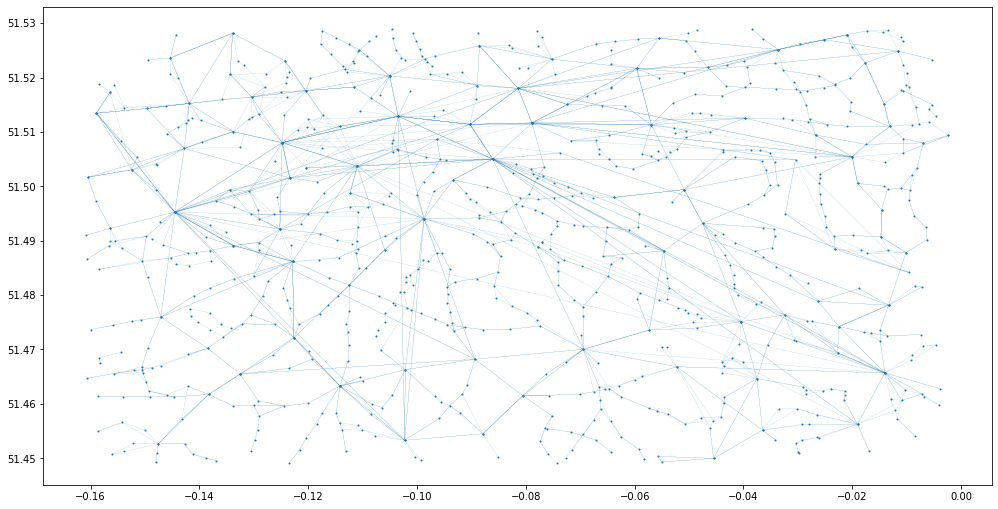

In [8]:
fig, ax = plt.subplots(figsize=(17, 17))
nodes.plot(ax=ax, markersize=1)
edges.plot(ax=ax, linewidth=0.1)
del fig, ax

In [9]:
nodes['osmid'] = nodes['node'].astype(str) + '_' + nodes['layer'].astype(str)
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.set_index('osmid', verify_integrity=True, inplace=True, drop=False) # keep the column as osmnx needs it (as well as it being the index of the DF)
nodes

,node,layer,lat,lon,zone,atcocode,geometry,osmid,x,y
osmid,,,,,,,,,,
20_5,20,5,51.45774,-0.12900,490,490G00009460,POINT (-0.12900 51.45774),20_5,-0.12900,51.45774
154_5,154,5,51.48817,-0.13813,490,490G00011004,POINT (-0.13813 51.48817),154_5,-0.13813,51.48817
259_5,259,5,51.51741,-0.12497,490,490G00010131,POINT (-0.12497 51.51741),259_5,-0.12497,51.51741
269_5,269,5,51.47554,-0.09672,490,490G00011846,POINT (-0.09672 51.47554),269_5,-0.09672,51.47554
335_5,335,5,51.46630,-0.10218,490,910GLBGHJN,POINT (-0.10218 51.46630),335_5,-0.10218,51.46630
...,...,...,...,...,...,...,...,...,...,...
260225_5,260225,5,51.47163,-0.03038,490,490009530S,POINT (-0.03038 51.47163),260225_5,-0.03038,51.47163
260275_5,260275,5,51.47299,-0.01661,490,490007514W,POINT (-0.01661 51.47299),260275_5,-0.01661,51.47299
262188_5,262188,5,51.51883,-0.15843,490,490009990N,POINT (-0.15843 51.51883),262188_5,-0.15843,51.51883


In [10]:
edges['u'] = edges['ori_node'].astype(str) + '_' + edges['ori_layer'].astype(str)
edges['v'] = edges['des_node'].astype(str) + '_' + edges['des_layer'].astype(str)
edges['key'] = edges.reset_index()['index']
edges['osmid'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
edges.set_index(['u', 'v', 'key'], inplace=True)
edges = edges.set_crs("EPSG:4326")
edges

ori_node  des_node  ori_layer  des_layer  minutes  \
u       v       key                                                       
7351_1  25717_1 0         7351     25717          1          1       14   
13745_1 35082_1 1        13745     35082          1          1        5   
        35743_1 2        13745     35743          1          1        5   
25717_1 7351_1  3        25717      7351          1          1       14   
        35082_1 4        25717     35082          1          1        4   
...                        ...       ...        ...        ...      ...   
50899_3 50899_5 2465     50899     50899          3          5        2   
51076_5 51076_1 2466     51076     51076          5          1        4   
51076_1 51076_5 2467     51076     51076          1          5        4   
94175_4 94175_5 2468     94175     94175          4          5        1   
94175_5 94175_4 2469     94175     94175          5          4        1   

                         km  \
u       v       key           
7351_1  25717_1 0     2.710   
13745_1 35082_1 1     1.483   
        35743_1 2     1.569   
25717_1 7351_1  3     2.710   
        35082_1 4     0.814   
...                     ...   
50899_3 50899_5 2465  0.155   
51076_5 51076_1 2466  0.251   
51076_1 51076_5 2467  0.251   
94175_4 94175_5 2468  0.000   
94175_5 94175_4 2469  0.000   

                                                               geometry  \
u       v       key                                                       
7351_1  25717_1 0     LINESTRING (-0.12523 51.49212, -0.09635 51.50863)   
13745_1 35082_1 1     LINESTRING (-0.10346 51.51287, -0.08609 51.50502)   
        35743_1 2     LINESTRING (-0.10346 51.51287, -0.12480 51.50803)   
25717_1 7351_1  3     LINESTRING (-0.09635 51.50863, -0.12523 51.49212)   
        35082_1 4     LINESTRING (-0.09635 51.50863, -0.08609 51.50502)   
...                                                                 ...   
50899_3 50899_5 2465  LINESTRING (-0.06376 51.49796, -0.06376 51.49796)   
51076_5 51076_1 2466  LINESTRING (-0.12038 51.50342, -0.12038 51.50342)   
51076_1 51076_5 2467  LINESTRING (-0.12038 51.50342, -0.12038 51.50342)   
94175_4 94175_5 2468  LINESTRING (-0.07712 51.48971, -0.07712 51.48971)   
94175_5 94175_4 2469  LINESTRING (-0.07712 51.48971, -0.07712 51.48971)   

                                osmid  
u       v       key                    
7351_1  25717_1 0      7351_1_25717_1  
13745_1 35082_1 1     13745_1_35082_1  
        35743_1 2     13745_1_35743_1  
25717_1 7351_1  3      25717_1_7351_1  
        35082_1 4     25717_1_35082_1  
...                               ...  
50899_3 50899_5 2465  50899_3_50899_5  
51076_5 51076_1 2466  51076_5_51076_1  
51076_1 51076_5 2467  51076_1_51076_5  
94175_4 94175_5 2468  94175_4_94175_5  
94175_5 94175_4 2469  94175_5_94175_4  

[2470 rows x 8 columns]

In [11]:
import osmnx
graph = osmnx.utils_graph.graph_from_gdfs(nodes, edges, None)

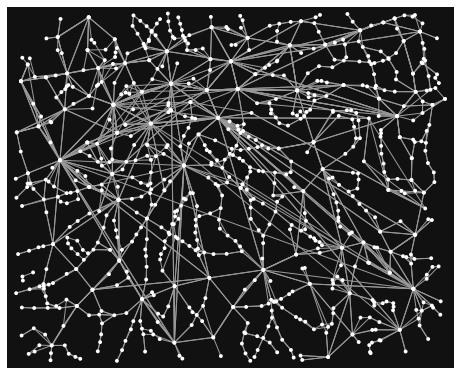

In [12]:
fig, ax = osmnx.plot_graph(graph)

In [13]:
osmnx.utils_graph.graph_to_gdfs(graph, nodes=False)

ori_node  des_node  ori_layer  des_layer  minutes  \
u        v        key                                                       
7351_1   25717_1  0         7351     25717          1          1       14   
         7351_4   2121      7351      7351          1          4        2   
         7351_5   2123      7351      7351          1          5        3   
25717_1  7351_1   3        25717      7351          1          1       14   
         35082_1  4        25717     35082          1          1        4   
...                          ...       ...        ...        ...      ...   
252358_5 120808_5 2056    252358    120808          5          5        1   
252643_5 811_5    2058    252643       811          5          5        1   
262344_5 252358_5 2071    262344    252358          5          5        1   
35458_2  35458_5  2355     35458     35458          2          5        4   
         35458_3  2358     35458     35458          2          3        4   

                           km  \
u        v        key           
7351_1   25717_1  0     2.710   
         7351_4   2121  0.161   
         7351_5   2123  0.188   
25717_1  7351_1   3     2.710   
         35082_1  4     0.814   
...                       ...   
252358_5 120808_5 2056  0.216   
252643_5 811_5    2058  0.436   
262344_5 252358_5 2071  0.153   
35458_2  35458_5  2355  0.329   
         35458_3  2358  0.273   

                                                                 geometry  \
u        v        key                                                       
7351_1   25717_1  0     LINESTRING (-0.12523 51.49212, -0.09635 51.50863)   
         7351_4   2121  LINESTRING (-0.12523 51.49212, -0.12523 51.49212)   
         7351_5   2123  LINESTRING (-0.12523 51.49212, -0.12523 51.49212)   
25717_1  7351_1   3     LINESTRING (-0.09635 51.50863, -0.12523 51.49212)   
         35082_1  4     LINESTRING (-0.09635 51.50863, -0.08609 51.50502)   
...                                                                   ...   
252358_5 120808_5 2056  LINESTRING (-0.14031 51.47499, -0.13800 51.47367)   
252643_5 811_5    2058  LINESTRING (-0.05501 51.47037, -0.05227 51.46683)   
262344_5 252358_5 2071  LINESTRING (-0.14156 51.47613, -0.14031 51.47499)   
35458_2  35458_5  2355  LINESTRING (-0.13392 51.52814, -0.13392 51.52814)   
         35458_3  2358  LINESTRING (-0.13392 51.52814, -0.13392 51.52814)   

                                    osmid  
u        v        key                      
7351_1   25717_1  0        7351_1_25717_1  
         7351_4   2121      7351_1_7351_4  
         7351_5   2123      7351_1_7351_5  
25717_1  7351_1   3        25717_1_7351_1  
         35082_1  4       25717_1_35082_1  
...                                   ...  
252358_5 120808_5 2056  252358_5_120808_5  
252643_5 811_5    2058     252643_5_811_5  
262344_5 252358_5 2071  262344_5_252358_5  
35458_2  35458_5  2355    35458_2_35458_5  
         35458_3  2358    35458_2_35458_3  

[2470 rows x 8 columns]

In [14]:
graph_node_ids = osmnx.utils_graph.graph_to_gdfs(graph, edges=False).osmid # the graph module removes some nodes (probably unconnected ones, TODO investigate)

In [15]:
%%time
# transit_node_positions = [tuple(coord) for coord in nodes.to_crs(OUT_CRS)[['x', 'y']].to_numpy()]
transit_node_positions = np.array(list(nodes.loc[graph_node_ids].to_crs(OUT_CRS).geometry.centroid.apply(lambda x: (x.x, x.y))))
nodeKdTree = cKDTree(data=transit_node_positions)

CPU times: user 203 ms, sys: 15.6 ms, total: 219 ms
Wall time: 219 ms


In [ ]:
# %%time
# amount = 10_000
# print(f'For {amount} iterations')
# for index, person in enumerate(people):
#     if index > amount:
#         break
#     osmnx.distance.get_nearest_node(graph, person.pos)

In [ ]:
# %%time
# print(f'For {len(people)} iterations')
# for index, person in enumerate(people):
#     nodeKdTree.query(x=person.pos, k=1)

In [16]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [17]:
# %%time
# work_nearest_nodes = cKDQueryRadius(trimmed_work, nodes, radius=1_500, workers=5)
# print_size(work_nearest_nodes)

In [18]:
# %%time
# nodes_nearest_households = cKDQueryRadius(nodes, households_gdf, radius=1_500, workers=5)
# print_size(nodes_nearest_households)

In [19]:
# %%time
# household_positions = list(households_gdf.geometry.centroid.apply(lambda x: (x.x, x.y)))
# households_kd_tree = cKDTree(data=household_positions)
# print_size(households_kd_tree) doesn't work

In [20]:
# %%time
# workplace_positions = [(x, y) for x, y in zip(trimmed_work.geometry.x, trimmed_work.geometry.y)]

In [21]:
# %%time
# for pos in workplace_positions:
#     households_kd_tree.query_ball_point(pos, 500)

In [22]:
households_gdf

,uid,inhabitants,geometry
0,0,3,POINT (528321.877 182711.925)
1,1,2,POINT (528106.593 182646.838)
2,2,3,POINT (528489.985 182698.677)
3,3,2,POINT (528278.628 182694.736)
4,4,3,POINT (528506.105 182704.682)
...,...,...,...
589971,589971,2,POINT (538764.344 174282.348)
589972,589972,2,POINT (538815.190 174343.419)
589973,589973,1,POINT (538764.344 174282.348)
589974,589974,1,POINT (538815.190 174343.419)


In [37]:
# TODO Remove when Person pickle is remade for South London
for person in people:
    person.pos = (person.pos.x, person.pos.y)

In [38]:
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'age': person.age} for person in people])
print_size(people_df)

'35.4MiB'

In [39]:
# people_gdf = geopandas.GeoDataFrame(people_df, geometry=geopandas.points_from_xy(people_df.x, people_df.y), crs=OUT_CRS)
# fig, ax = plt.subplots(figsize=(10,10))
# people_gdf.plot(ax=ax, marker_size=0.1)
# del fig, ax, test, people_gdf

In [40]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']

In [65]:
bucket_size = 250 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 37, x: 46


In [66]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()
print(len(unemployed))

542226


In [67]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size)).astype(int) - 1
unemployed['bucket_y'] = np.ceil(y_len - ((unemployed['y'] - boundary_miny) / bucket_size)).astype(int) - 1

In [68]:
# unemployed_bucket = np.array([[]] * (y_len * x_len) + [[1]], dtype=object)[:-1].reshape((y_len, x_len))

In [69]:
def make_buckets():
    unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
    for person in unemployed.itertuples():
        unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)
    
    return unemployed_bucket

In [70]:
%%time
unemployed_bucket = make_buckets()

CPU times: user 562 ms, sys: 0 ns, total: 562 ms
Wall time: 578 ms


In [71]:
len(unemployed_bucket)

37

In [72]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, centre_y=None, centre_x=None, radius=None):
    if centre_x is None: # use the middle of the image
        centre_x = int(w / 2)
    if centre_y is None:
        centre_y = int(h / 2)
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(centre_y, centre_x, (w - centre_x), (h - centre_y))

    y, x = np.ogrid[-centre_y:(h - centre_y), -centre_x:(w - centre_x)]
    mask = (x * x) + (y * y) <= (radius * radius)
    return mask

In [73]:
%%time
counts = np.array([list(map(len, row)) for row in unemployed_bucket])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 337 µs


In [74]:
%%time
mask = create_circular_mask(h=y_len, w=x_len)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 97 µs


In [75]:
indices = np.argwhere(mask)
indices.shape

(1009, 2)

In [76]:
%%time
probabilities = counts[mask] / np.sum(counts[mask])
probabilities.size

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 284 µs


1009

In [77]:
%%timeit
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 1_000, p=probabilities)

116 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


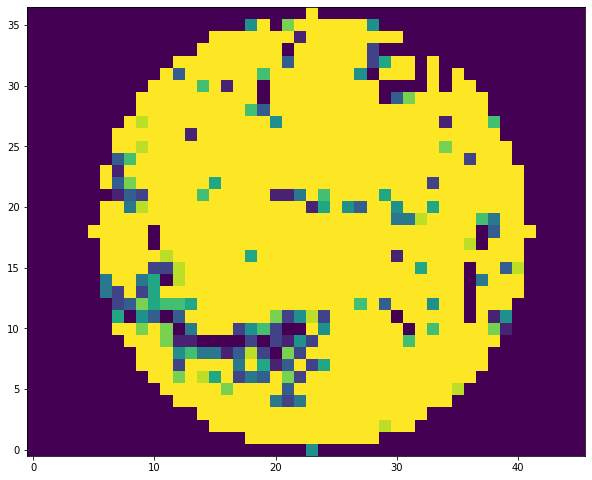

In [78]:
# sanity check the sampling matches the underlying probabilities
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 50_000, p=probabilities)

test = np.zeros(counts.shape)
for index, chosen in enumerate(chosen_buckets):
    test[tuple(indices[chosen])] += 1
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test, origin='lower', vmax=10)
del fig, ax, test, chosen_buckets

In [79]:
class NoViablePeopleError(Exception):
    pass

In [80]:
def valid_unemployed_within_dist(y, x, dist, cache_size=200):
    counts = np.array([list(map(len, row)) for row in unemployed_bucket])
    y = y_len - int(math.ceil((y - boundary_miny) / bucket_size)) - 1
    x = int(math.ceil((x - boundary_minx) / bucket_size)) - 1
    dist = dist / bucket_size
    mask = create_circular_mask(h=y_len, w=x_len, centre_y=y, centre_x=x, radius=dist)
    
    indices = np.argwhere(mask)
    if np.sum(counts[mask]) == 0:
        raise NoViablePeopleError(f'No viable unemployed people left around (x:{x}, y:{y})')
    probabilities = counts[mask] / np.sum(counts[mask])
#     print(f'x: {x}, y: {y}, indices: {indices}, probabilities: {probabilities}')
    
    chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities) # a cache of sampled choices
    chosen_iter = iter(chosen_buckets)
    failures = 0
    
    while True:
        try:
            next_bucket_pos = tuple(indices[next(chosen_iter)])
        except StopIteration: # used up the cache, repopulate with some more random choices
            chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
            chosen_iter = iter(chosen_buckets)
            continue
        try: 
            next_person = unemployed_bucket[next_bucket_pos[0]][next_bucket_pos[1]].pop()
        except IndexError: # no unemployed people in that bucket
            failures += 1
            if failures > 300: # we had a lot of failures, recalc the probability map
                failures = 0
                
                counts = np.array([list(map(len, row)) for row in unemployed_bucket])
                
                total_unemployed_left = np.sum(counts[mask])
                if total_unemployed_left == 0:
                    raise NoViablePeopleError(f'No viable unemployed people left around ({x}, {y})')
                
                probabilities = counts[mask] / total_unemployed_left
                
                chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
                chosen_iter = iter(chosen_buckets)
            continue
            
        yield next_person

(534924.7694278507, 181161.489427028)


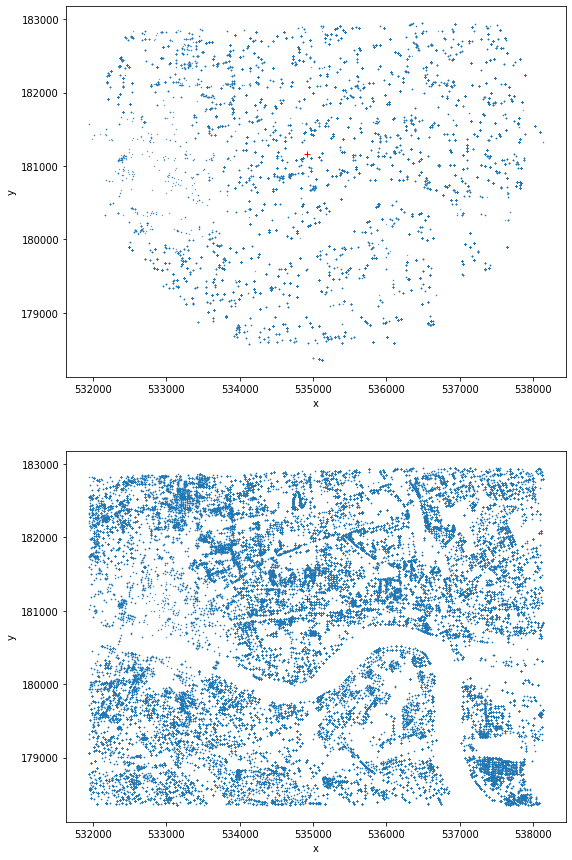

In [81]:
unemployed_bucket = make_buckets()

# pick a random workplace to query around
rand_workplace = trimmed_work.loc[[len(trimmed_work) // 3]]

(y, x) = (rand_workplace.geometry.y, rand_workplace.geometry.x)
# (y, x) = (397000, 385000)
print(f'({float(x)}, {float(y)})')
valid_unemployed_gen_5k = valid_unemployed_within_dist(y, x, 3_000)

# sanity check the sampling matches the underlying probabilities
chosen_people = [(next(valid_unemployed_gen_5k)) for i in range(45_000)]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 15))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
# sanity check
chosen = people_df.loc[chosen_people]
chosen.plot(ax=ax1, x='x', y='y', kind='scatter', s=0.1)
(xmin, xmax, ymin, ymax) = (chosen['x'].min(), chosen['x'].max(), chosen['y'].min(), chosen['y'].max())
people_df[(people_df['x'] > xmin) & (people_df['x'] < xmax) & (people_df['y'] > ymin) & (people_df['y'] < ymax)].plot(ax=ax2, x='x', y='y', kind='scatter', s=0.1)

ax1.plot(x, y, 'r+')
ax2.plot(x, y, 'r+')
# rand_workplace.plot(ax=ax1, markersize=100, c='red', marker='x')
# rand_workplace.plot(ax=ax2, markersize=100, c='red', marker='x')
del fig, ax1, ax2, chosen_people, chosen, xmin, ymin, xmax, ymax, rand_workplace

In [82]:
unemployed_bucket = make_buckets()
valid_unemployed_gen_5k = valid_unemployed_within_dist(y, x, 5_000)
%timeit -r 10 -n 15_000 next(valid_unemployed_gen_5k)

2.02 µs ± 72.5 ns per loop (mean ± std. dev. of 10 runs, 15000 loops each)


In [83]:
del valid_unemployed_gen_5k, y, x

In [84]:
# households within 60k
# generate a probability heatmap
# ravel and sample it
# if there are no free slots set it to 0
# if 100 misses in a row, regenerate probability map

In [85]:
# pick a random vector
# query-ball around that vector
# try X vectors, then new dist

In [86]:
%%time
# uses about 5-6GB of memory for Manchester with 4400 nodes and 6200 edges 
len_path = dict(nx.all_pairs_dijkstra(graph, cutoff=90, weight='minutes'))  # {node(str): ( {target(str): dist(num)}, {target(str): [...path_elements]} ) }

CPU times: user 4.53 s, sys: 15.6 ms, total: 4.55 s
Wall time: 4.53 s


In [87]:
from copy import deepcopy
MIN_TRAVEL_TIME = 15
graph_node_ids_to_index = {node_id: index for index, node_id in enumerate(list(graph_node_ids))}

transit_nodes_to_commuting_nodes = {graph_node_ids_to_index[src_node_id]: [target_node_id for target_node_id, time in times_dict.items() if time > MIN_TRAVEL_TIME] 
                   for src_node_id, (times_dict, _) in len_path.items()}

def get_transit_nodes_to_commuting_nodes():
    return deepcopy(transit_nodes_to_commuting_nodes)
    
del len_path, graph_node_ids_to_index

In [88]:
class NoNearbyTransitNodesError(Exception):
    pass

In [89]:
def get_nearby_transit_nodes(workplace):
    dist = 1_000
    nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    while len(nearby_transit_nodes) == 0 and dist <= 5_000:
        dist += 1000
        nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    if len(nearby_transit_nodes) == 0:
        raise NoNearbyTransitNodesError(f"No transit nodes were found within walking distance of workplace {workplace.index}")
    
    return nearby_transit_nodes

In [90]:
nodes_to_radius_search = dict(zip(list(graph_node_ids), list(map(lambda pos: valid_unemployed_within_dist(pos[1], pos[0], 5_000, 100), transit_node_positions))))

In [91]:
from enum import Enum
class TransportType(Enum):
    PUBLIC_TRANSIT = 0,
    DRIVING = 1,
    CYCLING = 2,
    WALKING = 3

In [92]:
%%time
to_allocate = len(unemployed)
print(f'Trying to allocate {to_allocate} people, {len(trimmed_work)} workplaces')

unemployed_bucket = make_buckets()
reachable_nodes = get_transit_nodes_to_commuting_nodes()

people_to_workplaces = [None] * len(people_df)
people_to_transport_type = [None] * len(people_df)

failures = 0
successes = 0
workplace_indices = []

for index, workplace in enumerate(trimmed_work.sample(frac=1).itertuples()): # iterate over shuffled workplaces
    if successes >= to_allocate:
        print(f'Allocated all people after {index} workplaces')
        break
    if index < 9:
        workplace_indices.append(workplace.index)
        
    transport_options = [TransportType.PUBLIC_TRANSIT, TransportType.DRIVING, TransportType.CYCLING, TransportType.WALKING]
    
    try:
        nearby_transit_nodes = get_nearby_transit_nodes(workplace)
    except NoNearbyTransitNodesError:
        transport_options.remove(TransportType.PUBLIC_TRANSIT)
        
    valid_unemployed_gen_60k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 60_000)
    valid_unemployed_gen_20k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 20_000)
    valid_unemployed_gen_5k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 5_000)
    
    for _ in range(workplace.capacity):
        # TODO update to better reflect real distributions if possible, maybe weight it by workplace size, more likely to walk if you own the business
        random.shuffle(transport_options)
        random_transport = iter(transport_options)
        
        person_id = None
        transport_type = None
        
        while (person_id == None):
            try:
                transport_type = next(random_transport)
            except StopIteration:
                break
            
            if transport_type == TransportType.PUBLIC_TRANSIT:
                source_node_index = np.random.choice(nearby_transit_nodes)
                try:
                    while (person_id == None):
                        dest_osmid = random.choice(reachable_nodes[source_node_index])
                        try:
                            person_id = next(nodes_to_radius_search[dest_osmid])
                        except StopIteration:
                            reachable_nodes[source_node_index].remove(dest_osmid)
                except (NoViablePeopleError, IndexError):
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.DRIVING:
                try:
                    person_id = next(valid_unemployed_gen_60k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.CYCLING:
                try:
                    person_id = next(valid_unemployed_gen_20k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.WALKING:
                try:
                    person_id = next(valid_unemployed_gen_5k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
        
        if person_id:
            if transport_type:
                people_to_transport_type[person_id] = transport_type
            
            people_to_workplaces[person_id] = workplace.index
            successes += 1
            if successes >= to_allocate:
                break
        else:
            failures +=1
            continue            
    
    # workplace_row.capacity
    # workplace.index    
    
print(f'Successes: {successes}, Failures: {failures}')

Trying to allocate 542226 people, 41375 workplaces
Allocated all people after 2506 workplaces
Successes: 542226, Failures: 0
CPU times: user 9.64 s, sys: 0 ns, total: 9.64 s
Wall time: 9.68 s


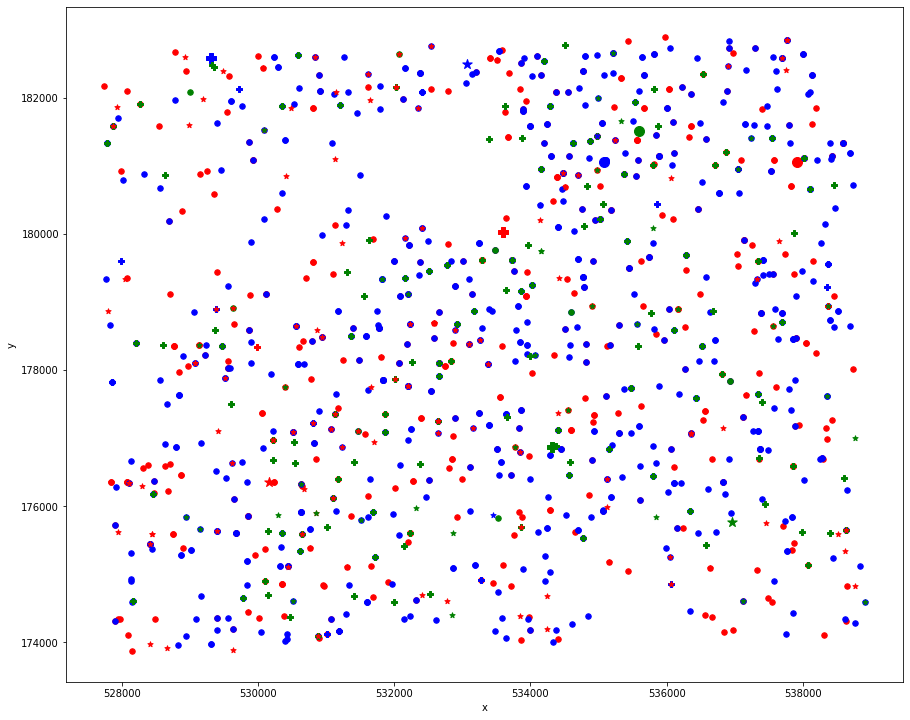

In [93]:
from collections import defaultdict
workplaces_to_people = defaultdict(list)
for person_id, workplace_index in enumerate(people_to_workplaces):
    if workplace_index is not None:
        workplaces_to_people[workplace_index].append(person_id)

pls = {ind: workplaces_to_people[ind] for ind in workplace_indices}

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
marker_styles = [
                ('red', 'o'), ('blue', 'o'), ('green', 'o'),
                ('red', 'P'), ('blue', 'P'), ('green', 'P'),
                ('red', '*'), ('blue', '*'), ('green', '*')
                ]

for (workplace_index, worker_indices), (color, marker) in zip(pls.items(), marker_styles):
    trimmed_work.iloc[[workplace_index]].plot(ax=ax, markersize=100, c=color, marker=marker)
    workers = people_df.iloc[worker_indices]
    workers.plot(ax=ax, x='x', y='y', kind='scatter', s=30, c=color, marker=marker)
del fig, ax, workplaces_to_people